In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("pastel")
%matplotlib inline

In [2]:
data_path = Path('../data/output.csv')
df = pd.read_csv(data_path)

In [3]:
df.describe()

,Year,Rate
count,885548.000000,885548.000000
mean,2003.000017,6.175010
std,7.824893,3.112535
min,1990.000000,0.000000
25%,1996.000000,4.000000
50%,2003.000000,5.500000
75%,2010.000000,7.700000
max,2016.000000,58.400000


In [4]:
df['Date'] = df.apply(lambda x: x.Month+' '+str(x.Year), axis=1)
df.Date = pd.to_datetime(df.Date)

In [5]:
df = df.drop(['Year', 'Month'], axis=1)

In [6]:
df.head()

,State,County,Rate,Date
0,Mississippi,Newton County,6.1,2015-02-01
1,Mississippi,Panola County,9.4,2015-02-01
2,Mississippi,Monroe County,7.9,2015-02-01
3,Mississippi,Hinds County,6.1,2015-02-01
4,Mississippi,Kemper County,10.6,2015-02-01


In [7]:
df_ny = df[df.State =='New York']
df_ny = df_ny.reset_index().set_index('Date').drop(['index'], axis=1)
df_ny = df_ny.sort_values('Date')

In [8]:
df_ny.head()

,State,County,Rate
Date,,,
1990-01-01,New York,Wyoming County,8.0
1990-01-01,New York,Chenango County,6.5
1990-01-01,New York,Westchester County,3.5
1990-01-01,New York,Otsego County,6.8
1990-01-01,New York,New York County,6.6


In [9]:
df_c = df[df.State =='California']
df_c = df_c.reset_index().set_index('Date').drop(['index'], axis=1)
df_c = df_c.sort_values('Date')

In [10]:
df_c.head()

,State,County,Rate
Date,,,
1990-01-01,California,Plumas County,16.2
1990-01-01,California,Lake County,10.8
1990-01-01,California,El Dorado County,5.0
1990-01-01,California,Solano County,4.7
1990-01-01,California,Los Angeles County,6.0


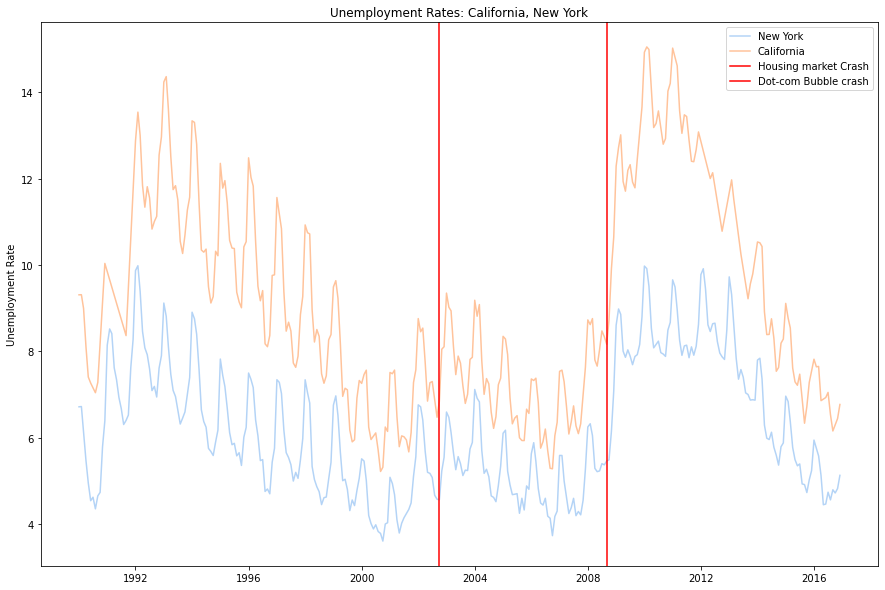

In [11]:
plt.figure(figsize=(15,10))


plt.plot(df_ny.groupby('Date').mean(), alpha = 0.8)
plt.plot(df_c.groupby('Date').mean(), alpha = 0.8)


plt.axvline(x=pd.to_datetime('September 2008'),  c='r')
plt.axvline(x=pd.to_datetime('October 2002'),  c='r')


# plt.legend()
plt.ylabel('Unemployment Rate')

plt.legend(['New York','California', 'Housing market Crash', 'Dot-com Bubble crash'])
plt.title('Unemployment Rates: California, New York')
plt.savefig('../Images/ny_ca_events.png')
plt.show()


In [12]:
df_ny['roll_7'] = df_ny.rolling(window = 10).mean().fillna(0)

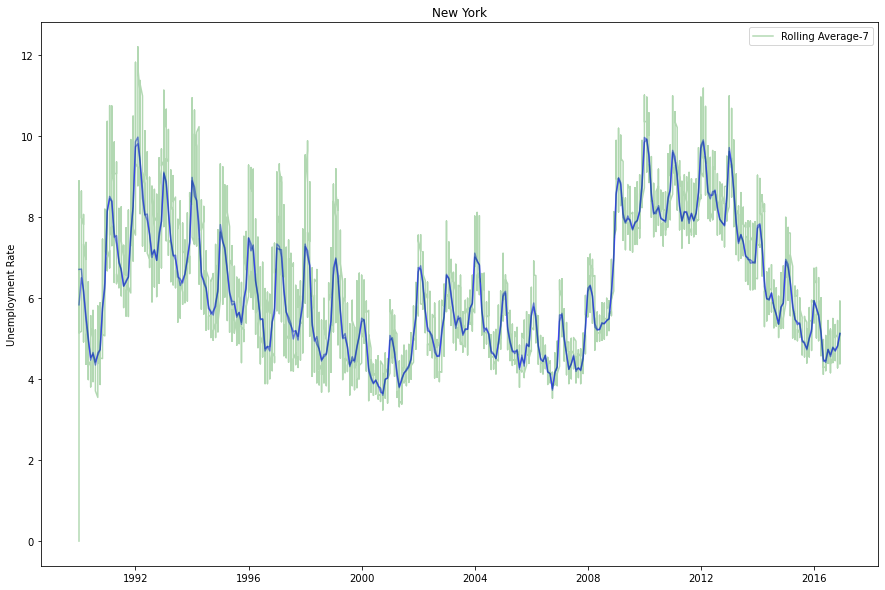

In [13]:
plt.figure(figsize=(15,10))


plt.plot(df_ny.groupby('Date').mean(), alpha = 0.5, c='b')
plt.plot(df_ny.roll_7, alpha=0.3, c='g', label='Rolling Average-7')

plt.ylabel('Unemployment Rate')

plt.legend()
plt.title('New York')
plt.savefig('../Images/ny_rolling_avg.png')
plt.show()
df_ny = df_ny.drop(['roll_7'], axis=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


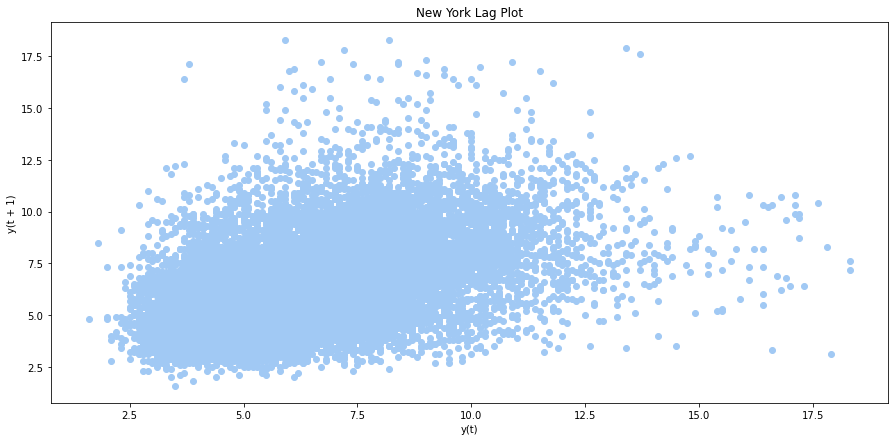

In [14]:
plt.figure(figsize=(15,7))
pd.plotting.lag_plot(df_ny.Rate)
plt.title('New York Lag Plot')
plt.savefig('../Images/ny_lag_plot.png')

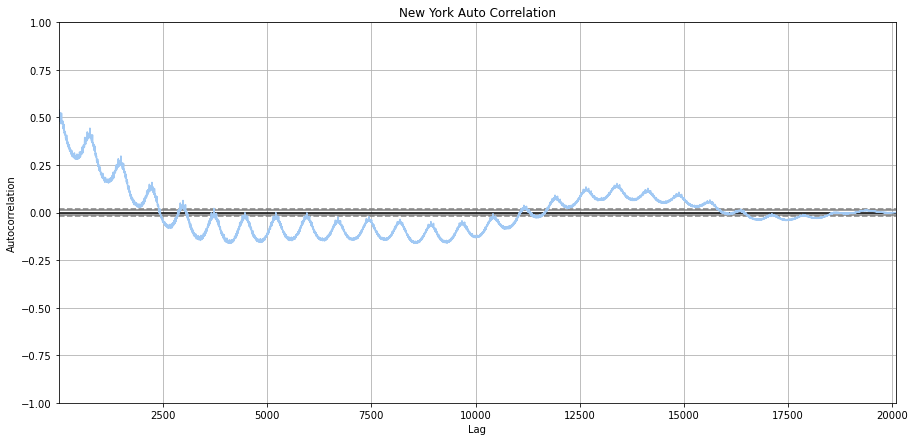

In [15]:
plt.figure(figsize=(15,7))
pd.plotting.autocorrelation_plot(df_ny.Rate)
plt.title('New York Auto Correlation')
plt.savefig('../Images/ny_auto_corr.png')

Creating Lag variables

In [16]:
df_ny['Rate_lag_1'] = df_ny.groupby('County')['Rate'].shift(1)
df_ny['Rate_lag_2'] = df_ny.groupby('County')['Rate'].shift(2)
df_ny['Rate_lag_3'] = df_ny.groupby('County')['Rate'].shift(3)
df_ny['Rate_rolling_1']  = df_ny.groupby('County')['Rate'].rolling(window=1).mean().values
df_ny['Rate_rolling_3']  = df_ny.groupby('County')['Rate'].rolling(window=3).mean().values
df_ny['Rate_rolling_7']  = df_ny.groupby('County')['Rate'].rolling(window=7).mean().values
df_ny = df_ny.fillna(0)

In [17]:
df_ny.head()

,State,County,Rate,Rate_lag_1,Rate_lag_2,Rate_lag_3,Rate_rolling_1,Rate_rolling_3,Rate_rolling_7
Date,,,,,,,,,
1990-01-01,New York,Wyoming County,8.0,0.0,0.0,0.0,3.3,0.000000,0.0
1990-01-01,New York,Chenango County,6.5,0.0,0.0,0.0,3.3,0.000000,0.0
1990-01-01,New York,Westchester County,3.5,0.0,0.0,0.0,3.0,3.200000,0.0
1990-01-01,New York,Otsego County,6.8,0.0,0.0,0.0,2.5,2.933333,0.0
1990-01-01,New York,New York County,6.6,0.0,0.0,0.0,2.6,2.700000,0.0


In [18]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [19]:
def tts(X, y, test_size=0.3):
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test

In [20]:
df_ny_nyc = df_ny[df_ny.County == 'New York County']
df_ny_nyc = df_ny_nyc.drop(['State', 'County'], axis = 1)

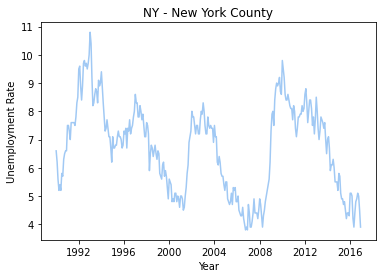

In [21]:
plt.plot(df_ny[df_ny.County == 'New York County']['Rate'])
plt.title('NY - New York County')
plt.ylabel('Unemployment Rate')
plt.xlabel('Year')
plt.savefig('../Images/ny_nycounty_rate.png')

In [22]:
df_ny_nyc.head()

,Rate,Rate_lag_1,Rate_lag_2,Rate_lag_3,Rate_rolling_1,Rate_rolling_3,Rate_rolling_7
Date,,,,,,,
1990-01-01,6.6,0.0,0.0,0.0,2.6,2.700000,0.000000
1990-02-01,6.2,6.6,0.0,0.0,2.6,2.733333,3.057143
1990-03-01,5.6,6.2,6.6,0.0,4.1,4.333333,3.928571
1990-04-01,5.2,5.6,6.2,6.6,3.8,3.900000,3.914286
1990-05-01,5.4,5.2,5.6,6.2,7.5,6.766667,6.942857


In [23]:
y = df_ny_nyc.Rate
df_ny_nyc = df_ny_nyc.drop(['Rate'], axis = 1)

In [24]:
X = df_ny_nyc

In [25]:
X_train, X_test, y_train, y_test = tts(X, y)

model = RandomForestRegressor(max_depth=10, n_estimators=100)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [26]:
timeseries_cv = TimeSeriesSplit(n_splits=3)
cv = cross_val_score(model, X_train, y_train, 
                     cv=timeseries_cv, scoring='neg_mean_absolute_error')
mae = -1 * cv.mean()
deviation = cv.std()

In [27]:
mae, deviation

(0.4616640614134342, 0.04837209952859134)

In [28]:
prediction = model.predict(X_test)
scale = 1.96
margin_error = mae + scale * deviation
lower = prediction - margin_error
upper = prediction + margin_error

f_alpha = 0.2
f_color = '#86F2E3'

C:\Users\Aaron\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Aaron\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


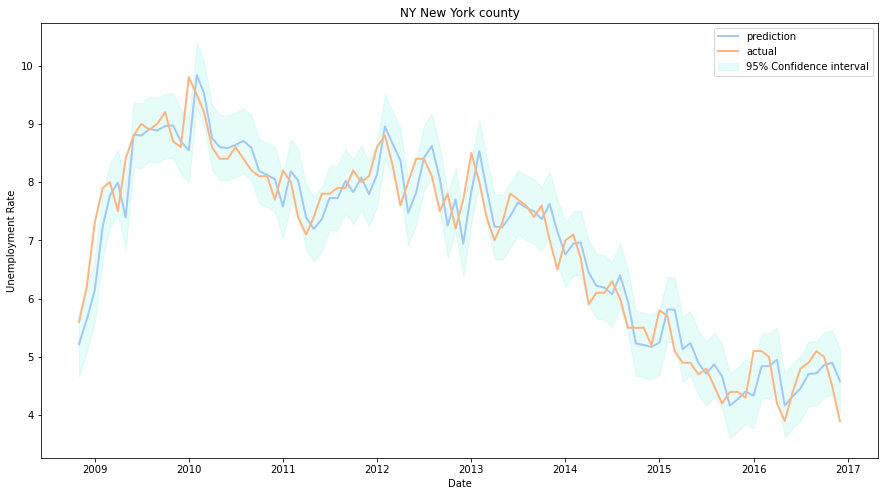

In [29]:
plt.figure(figsize=(15, 8))

plt.fill_between(y_test.index, lower, upper, color=f_color, alpha=f_alpha, label='95% Confidence interval')   
sns.lineplot(y_test.index, prediction, label='prediction', linewidth=2.0)
sns.lineplot(y_test.index, y_test, label='actual',linewidth=2.0)

plt.title('NY New York county')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.savefig('../Images/ny_county_model.png')
plt.show()

In [30]:
def get_predictions(df2, state, county, plot = True):
    
    dfk = df2.copy(deep= True)
    
    
    dfk = dfk[dfk.State == state]
    
    dfk['Rate_lag_1'] = dfk.groupby('County')['Rate'].shift(1)
    dfk['Rate_lag_2'] = dfk.groupby('County')['Rate'].shift(2)
    dfk['Rate_lag_3'] = dfk.groupby('County')['Rate'].shift(3)
    dfk['Rate_lag_7'] = dfk.groupby('County')['Rate'].shift(7)
    
    dfk['Rate_rolling_1']  = dfk.groupby('County')['Rate'].rolling(window=1).mean().values
    dfk['Rate_rolling_3']  = dfk.groupby('County')['Rate'].rolling(window=3).mean().values
    dfk['Rate_rolling_7']  = dfk.groupby('County')['Rate'].rolling(window=7).mean().values

    dfk = dfk.fillna(0)

    dfk = dfk[dfk.County == county]
    dfk = dfk.drop(['State', 'County'], axis = 1)
    
    y = dfk.Rate
    dfk = dfk.drop(['Rate','Date'], axis = 1)
    X = dfk
#     print(X)
    X_train, X_test, y_train, y_test = tts(X, y)

    model = RandomForestRegressor(max_depth=6, n_estimators=50)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    if plot:
        plt.figure(figsize=(15, 8))

        plt.plot(y_test.index, prediction, label='prediction', linewidth=2.0)
        plt.plot(y_test.index, y_test, label='actual', linewidth=2.0, alpha= 0.5)

        plt.title(f'{state} {county}')
        plt.ylabel('Unemployment Rate')
        plt.legend()
        plt.show()

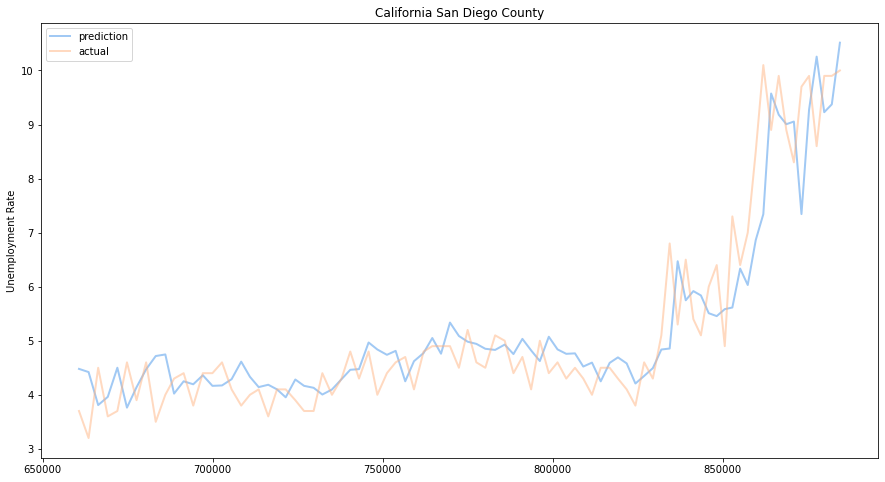

<Figure size 432x288 with 0 Axes>

In [31]:
get_predictions(df, 'California', 'San Diego County', plot=True)
plt.savefig('../Images/ca_model.png')